In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats import pearsonr

# Load news data
news_df = pd.read_csv('../Data/raw_analyst_ratings.csv')
news_df.columns = news_df.columns.str.lower()

# Convert 'date' to datetime
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')

# Drop rows with invalid/missing dates
news_df = news_df.dropna(subset=['date'])

# Handle timezone: localize only if not already tz-aware
if news_df['date'].dt.tz is None:
    news_df['date'] = news_df['date'].dt.tz_localize('UTC')

# Convert to New York timezone
news_df['date'] = news_df['date'].dt.tz_convert('America/New_York')

# Extract date only
news_df['date_only'] = news_df['date'].dt.date

# Load stock data
stocks = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']
stock_data = {}

for stock in stocks:
    df = pd.read_csv(f'../Data/yfinance_data/{stock}_historical_data.csv')
    df.columns = df.columns.str.lower()
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date'])  # remove any malformed date rows
    df['date_only'] = df['date'].dt.date
    stock_data[stock] = df

# Filter news for relevant stocks
news_df = news_df[news_df['stock'].isin(stocks)]

# Print previews
print("News Data Preview:")
print(news_df.head())

print("\nAAPL Stock Data Preview:")
print(stock_data['AAPL'].head())


News Data Preview:
      unnamed: 0                                           headline  \
6680        7120  Tech Stocks And FAANGS Strong Again To Start D...   
6681        7121      10 Biggest Price Target Changes For Wednesday   
6682        7122  Benzinga Pro's Top 5 Stocks To Watch For Wed.,...   
6683        7123  Deutsche Bank Maintains Buy on Apple, Raises P...   
6684        7124  Apple To Let Users Trade In Their Mac Computer...   

                                                    url          publisher  \
6680  https://www.benzinga.com/government/20/06/1622...         JJ Kinahan   
6681  https://www.benzinga.com/analyst-ratings/price...         Lisa Levin   
6682  https://www.benzinga.com/short-sellers/20/06/1...  Benzinga Newsdesk   
6683  https://www.benzinga.com/news/20/06/16219873/d...  Benzinga Newsdesk   
6684  https://www.benzinga.com/news/20/06/16218697/a...      Neer Varshney   

                          date stock   date_only  
6680 2020-06-10 11:33:26-04:00  AA

In [7]:
# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Calculate sentiment scores
news_df['sentiment'] = news_df['headline'].apply(
    lambda x: analyzer.polarity_scores(x)['compound']
)

# Aggregate daily sentiment scores per stock
daily_sentiment = news_df.groupby(['stock', 'date_only'])['sentiment'].mean().reset_index()
print("Daily Sentiment Scores Preview:")
print(daily_sentiment.head())

Daily Sentiment Scores Preview:
  stock   date_only  sentiment
0  AAPL  2020-06-09   0.246900
1  AAPL  2020-06-10   0.198850
2  AMZN  2020-06-09   0.077775
3  AMZN  2020-06-10   0.391233
4  GOOG  2020-06-04   0.000000


In [9]:
# Calculate daily returns for each stock
for stock in stocks:
    df = stock_data[stock]
    df['daily_return'] = df['close'].pct_change() * 100  # Percentage change
    stock_data[stock] = df

# Extract relevant columns (date_only, daily_return) into a single DataFrame
returns_df = pd.concat(
    [stock_data[stock][['date_only', 'daily_return']].assign(stock=stock)
     for stock in stocks]
)
returns_df = returns_df.dropna()
print("Daily Returns Preview:")
print(returns_df.head())

Daily Returns Preview:
    date_only  daily_return stock
1  1980-12-15     -5.217061  AAPL
2  1980-12-16     -7.339788  AAPL
3  1980-12-17      2.475091  AAPL
4  1980-12-18      2.899246  AAPL
5  1980-12-19      6.102867  AAPL


In [11]:
# Merge sentiment and returns
merged_df = pd.merge(
    daily_sentiment,
    returns_df,
    on=['stock', 'date_only'],
    how='inner'
)

# Calculate correlation per stock
correlations = {}
for stock in stocks:
    stock_data = merged_df[merged_df['stock'] == stock]
    if len(stock_data) > 1:  # Need at least 2 data points for correlation
        corr, _ = pearsonr(stock_data['sentiment'], stock_data['daily_return'])
        correlations[stock] = corr
    else:
        correlations[stock] = None
        print(f"Insufficient data for {stock} correlation")

print("Correlation Coefficients:")
for stock, corr in correlations.items():
    print(f"{stock}: {corr}")

Insufficient data for META correlation
Insufficient data for MSFT correlation
Insufficient data for TSLA correlation
Correlation Coefficients:
AAPL: 1.0
AMZN: -1.0
GOOG: -0.23437112074779948
META: None
MSFT: None
NVDA: 0.5227409232936001
TSLA: None


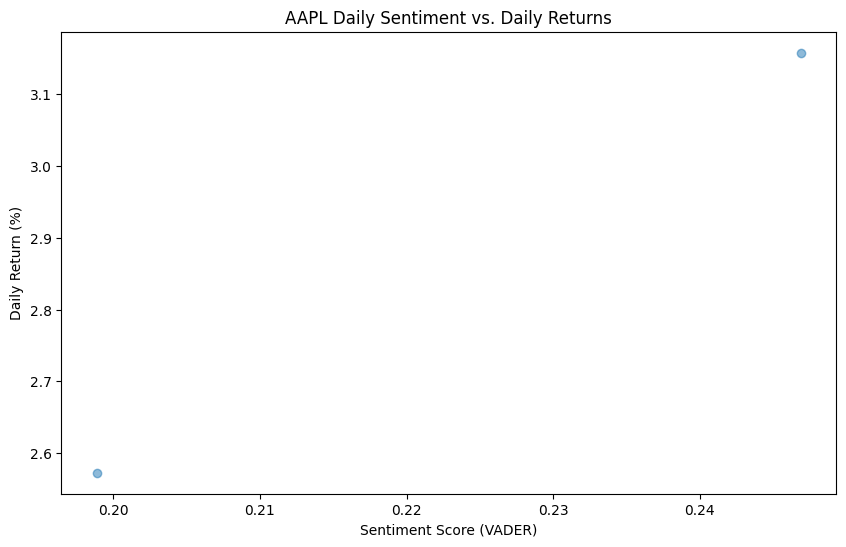

In [13]:
# Scatter plot for AAPL
aapl_data = merged_df[merged_df['stock'] == 'AAPL']
plt.figure(figsize=(10, 6))
plt.scatter(aapl_data['sentiment'], aapl_data['daily_return'], alpha=0.5)
plt.title('AAPL Daily Sentiment vs. Daily Returns')
plt.xlabel('Sentiment Score (VADER)')
plt.ylabel('Daily Return (%)')
plt.savefig('../notebooks/aapl_sentiment_vs_returns.png')
plt.show()

In [15]:
print("Sentiment Score Statistics:")
print(news_df['sentiment'].describe())
print("\nSentiment Score Bins:")
print(news_df['sentiment'].value_counts(bins=10))

print("\nNews Articles per Stock:")
print(news_df['stock'].value_counts())

from scipy.stats import pearsonr
correlations = {}
for stock in stocks:
    stock_data = merged_df[merged_df['stock'] == stock]
    if len(stock_data) > 1:
        corr, p_value = pearsonr(stock_data['sentiment'], stock_data['daily_return'])
        correlations[stock] = (corr, p_value)
    else:
        correlations[stock] = (None, None)
print("\nCorrelation Coefficients and P-values:")
for stock, (corr, p_value) in correlations.items():
    print(f"{stock}: Correlation = {corr}, P-value = {p_value}")

Sentiment Score Statistics:
count    50.000000
mean      0.204638
std       0.355587
min      -0.840200
25%       0.000000
50%       0.114750
75%       0.509450
max       0.817600
Name: sentiment, dtype: float64

Sentiment Score Bins:
(-0.0113, 0.154]     22
(0.486, 0.652]        9
(0.154, 0.32]         6
(0.32, 0.486]         5
(0.652, 0.818]        5
(-0.843, -0.674]      2
(-0.674, -0.509]      1
(-0.177, -0.0113]     0
(-0.509, -0.343]      0
(-0.343, -0.177]      0
Name: count, dtype: int64

News Articles per Stock:
stock
AAPL    10
AMZN    10
GOOG    10
NVDA    10
TSLA    10
Name: count, dtype: int64

Correlation Coefficients and P-values:
AAPL: Correlation = 1.0, P-value = 1.0
AMZN: Correlation = -1.0, P-value = 1.0
GOOG: Correlation = -0.23437112074779948, P-value = 0.7043443244448068
META: Correlation = None, P-value = None
MSFT: Correlation = None, P-value = None
NVDA: Correlation = 0.5227409232936001, P-value = 0.4772590767064
TSLA: Correlation = None, P-value = None


In [17]:
print("\nDaily Return Statistics (%):")
print(returns_df['daily_return'].describe())


Daily Return Statistics (%):
count    45421.000000
mean         0.137717
std          2.923803
min        -51.869199
25%         -1.155768
50%          0.053622
75%          1.375422
max         42.414762
Name: daily_return, dtype: float64
